In [1]:
# import jaxlib
# from jax_unirep import get_reps
import os
from time import time

from collections import defaultdict
# from UniRep.unirep_utils import get_UniReps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import label_binarize

from scipy import interp
from itertools import cycle

from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

import warnings
warnings.filterwarnings('ignore')

# Importing UniProt Data

In [2]:
# Importing the true data sets with unirep features
human_unirep_noSP = pd.read_pickle('UniRep_datasets/combined_human_UniRep_dataset_noSP.pkl')
human_unirep_withSP = pd.read_pickle('UniRep_datasets/combined_human_UniRep_dataset_withSP.pkl')

## New version

In [21]:
def train_opt_model(model_class, parameters, X_train, y_train, scoring, refit_sc):
    """Trains a classifier with 5 fold cross validation.
    
    Trains a classifier on training data performing 5 fold cross validation and testing multiple parameters.
    
    
    Inputs:
        model_class: the sklearn class of the classifier
        parameters: a parameter grid dictionary with the parameters and values to test
        X_train: features of the training set
        y_train: classes of the training set
        scoring: a sklearn scoring object with the score metrics to use
        refit_sc: the score metric to select the parameters that yield the best classifier
        
    Outputs:
        clf: the trained classifier
    """
    clf = GridSearchCV(model_class, parameters, cv=5, scoring=scoring, refit=refit_sc, verbose=2, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

In [4]:
def plot_param_search_1d(trained_model, parameters):

    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trained_model.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_Accuracy))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}   
    
    param_df = pd.DataFrame(scores_dict)
    
    sns.lineplot(parameters[param_names[0]], acc_eval_scores)
    
    plt.ylabel("AUC")
    plt.xlabel(param_names[0])
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [5]:
def plot_param_search(trained_model, parameters):
    # assert que parameters son exactament 2, sino no es pot fer
    
    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
    
    # select the parameter with more values as x axis (reverse if necessary)
    if len(param_values[0]) < len(param_values[1]):
        param_values.reverse()
        param_names.reverse()
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trn_clf.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_AUC).reshape(len(param_values[0]), len(param_values[1])))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}
    # series
    for it, series_vals in enumerate(param_values[1]):
        scores_dict[series_vals] = acc_eval_scores[it,]
    
    
    param_df = pd.DataFrame(scores_dict)
    
    param_plot = pd.melt(param_df, id_vars=param_names[0], value_vars=param_values[1], var_name=param_names[1], value_name="AUC")

    sns.lineplot(x=param_names[0], y="AUC", hue=param_names[1], data=param_plot)
    
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [6]:
def plot_roc_curve(trained_classifier, model_name, X_test, y_test, roc_col):
    # adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Binarize the output
    y_labs = label_binarize(y_test, classes=['cytoplasm', 'membrane','secreted'])
    n_classes = y_labs.shape[1]
    
    pred_probs = trained_classifier.best_estimator_.predict_proba(X_test)
    preds = trn_clf.best_estimator_.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, preds) 
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_labs[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=str(model_name)+', AUC: {:.3f}'.format(roc_auc["macro"]),
             color=roc_col, linestyle=':', linewidth=1)
    
    return test_accuracy, roc_auc["macro"]

In [7]:
# Running the model comparison on human data set WITH signal peptides
X = np.stack(human_unirep_withSP["UniRep"].to_numpy())
y = np.array(human_unirep_withSP['location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model_names = [
#     'kNN',
#                'Ridge',
#                'RandomForest',
#                'MLP',
#                'RBF SVM',
               'linear SVM'
              ]
models = [
#     KNeighborsClassifier(),
#           RidgeClassifier(normalize=True),
#           RandomForestClassifier(),
# #           MLPClassifier(max_iter=200),
#           SVC(kernel='rbf'),
          SVC(kernel='linear')
         ]

params = [
    # for kNN
#     {'n_neighbors':[int(np.sqrt(len(y_train))/16),
#                        int(np.sqrt(len(y_train))/8),
#                        int(np.sqrt(len(y_train))/4),
#                        int(np.sqrt(len(y_train))/2),
#                        int(np.sqrt(len(y_train))),
#                        int(np.sqrt(len(y_train))*2),
#                        int(np.sqrt(len(y_train))*4)],
#     'weights': ['uniform', 'distance']},
    # for Ridge
    
    # for RandomForest works fine
#     {'n_estimators':[1,5,10,20],
#      'max_depth':[1,10,30,60,150]},
    # for MLP works fine but slow
#     {'hidden_layer_sizes':[50,100],
# #      'alpha':[1e-4,1e-2,1e-1]},
#     {'hidden_layer_sizes':[10],
#      'alpha':[1e-4,1e-2]},
#     # for RBF SVM
#     {'C':[0.01,0.1],
#      'gamma':['auto']},
#      'gamma':['scale','auto']},
    # for linear SVM
    {'C':[0.01,0.1]}
]



#     models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
#     K_neighbors = int(np.sqrt(len(y_train)))
#     models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
#     models.append(('NeuralNet', MLPClassifier(max_iter=200)))
#     models.append(('RandomForest', RandomForestClassifier()))
#     models.append(('RBF SVM', SVC(gamma=0.1, C=1, kernel='linear')))

In [30]:
# ovo: One versus One and averaging macro, not affected by class imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
scoring = {'Accuracy': make_scorer(accuracy_score),
           'AUC':'roc_auc_ovo'}
refit_sc = 'AUC'

In [32]:
trained_models = []
scoring = {'Accuracy': make_scorer(accuracy_score)}
#            'AUC':'roc_auc_ovo'}
refit_sc = 'Accuracy'

for model, parameters, mod_name in zip(models,params, model_names):
    print("Started training model", mod_name)
    time_0 = time()
    trn_clf = train_opt_model(model, parameters, X_train, y_train, scoring, refit_sc)
    print("Finished training model in", round(time()-time_0,2),"seconds\n")

    if len(parameters) == 2:
        plot_param_search(trn_clf, parameters)   
    else:
        plot_param_search_1d(trn_clf, parameters)
    
    trained_models.append(trn_clf)
    print("---------------------------\n")

Started training model linear SVM
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Finished training model in 59.78 seconds

For the model optimized by AUC:


KeyError: 'rank_test_AUC'

Started training model linear SVM
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Finished training model in 112.24 seconds

For the model optimized by AUC:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
For the model optimized by Accuracy:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
Optimizing by AUC so best parameters are: {'C': 0.01}


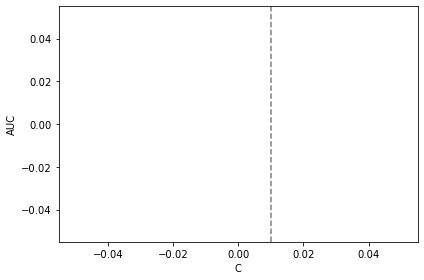

---------------------------



In [31]:
trained_models = []

for model, parameters, mod_name in zip(models,params, model_names):
    print("Started training model", mod_name)
    time_0 = time()
    trn_clf = train_opt_model(model, parameters, X_train, y_train, scoring, refit_sc)
    print("Finished training model in", round(time()-time_0,2),"seconds\n")

    if len(parameters) == 2:
        plot_param_search(trn_clf, parameters)   
    else:
        plot_param_search_1d(trn_clf, parameters)
    
    trained_models.append(trn_clf)
    print("---------------------------\n")

finished 1


AttributeError: predict_proba is not available when  probability=False

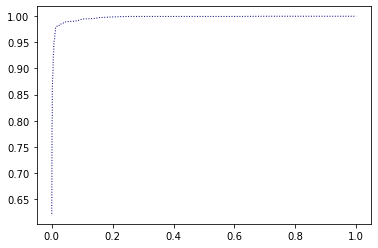

In [25]:
compare_auc = []
compare_accuracy = []
roc_colors = ['navy','orange','green','peru','red','violet']

for trn_model, mod_name, roc_col in zip(trained_models, model_names, roc_colors):
    test_accuracy, test_auc_val = plot_roc_curve(trn_model, mod_name, X_test, y_test, roc_col)
    compare_auc.append(test_auc_val)
    compare_accuracy.append(test_accuracy)
    
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

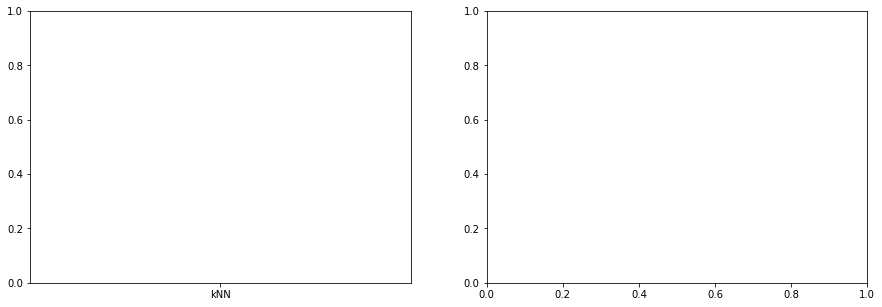

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(model_names, compare_auc)
axs[1].bar(model_names, compare_accuracy)

axs[0].set_ylabel('AUC')
axs[1].set_ylabel('Accuracy')

axs[0].set_ylim(0.7,1.0)
axs[1].set_ylim(0.7,1.0)

plt.show()

# Functions

In [5]:
def data_to_unirep(df):
    """
    Generates a new data frame with the UniProt ID, UniRep 1900 vectors (x-values), and secretion state (y-values)
    
    Args:
        df (DataFrame): original data frame with sequence information and class information (specifying secretion)
        
    Returns:
        unirep_df (DataFrame): new unirep data frame with class information and unirep vectors
    """
    seq_key = 'Sequence'
    vec_prefix = 'Vec_{}'
    
    # Generating new data frame with unirep vectors
    vec_column_names = [vec_prefix.format(i) for i in range(1900)]        
    unirep_df = pd.DataFrame(columns = ['Class'] + vec_column_names)

    for i, row in df.iterrows():
        if int(i) % 1 == 0:
            print('row {}'.format(i), end='\r')
        sequence = row.loc[seq_key]
        unirep_df.loc[i, 'Class'] = row['Class']
        vec = get_UniReps(sequence)[0][0]
        unirep_df.loc[i, vec_column_names] = vec
    
    return unirep_df

In [32]:
def classifier_comparison(X, y, seed):
    """
    Iterates through sklearn supervised learning classification models.
    Performs k-fold cross-validation (k=10).
    Comparing each classifier based on model accuracy.
    Plots model accuracy on a boxplot.
    Taken from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    
    Args:
        X (Array-like): All of the input parameters (including UniRep vectors) for the secretion analysis model
        y (Array-like): The ouput parameter, or secretion class, for the secretion analysis model
        
    Returns:
        
    """
    # Preparing models
    models = []
    models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
    K_neighbors = int(np.sqrt(len(y_train)))
    models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
    models.append(('NeuralNet', MLPClassifier(max_iter=200)))
    models.append(('RandomForest', RandomForestClassifier()))
    models.append(('RBF SVM', SVC(gamma=0.1, C=1)))
    
    # Evaluating each model using cross-validation
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # Plotting the classifier comparison
    fig = plt.figure()
    fig.suptitle('Sklearn Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [33]:
k_init_aprox = int(np.sqrt(len(y_train)))
parameters = {'n_neighbors':[int(k_init_aprox/8),
                       int(k_init_aprox/4),
                       int(k_init_aprox/2),
                       int(k_init_aprox),
                       int(k_init_aprox*2),
                       int(k_init_aprox*4),
                       int(k_init_aprox*8)],
             'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [9, 19, 39, 79, 158, 316, 632],
                         'weights': ['uniform', 'distance']})

In [ ]:
def 

In [8]:
# These parameters are for the `use_additional_features` function
# They are from the Hessa et al. paper cited in the function
params = pd.read_csv('Params.csv', header=None)
lst = params[0].values
params.set_index(lst, inplace=True)
del params[0]
params_dict = defaultdict(list)
for i, row in params.iterrows():
    for position in range(1, len(row) + 1):
        params_dict[i].append(float(row.loc[position]))

In [9]:
def use_additional_features(df):
    """
    Uses additional features to help improve the model. 
    Additional features include:
        theoretical isoelectric point, amino acid length, amino acid weight,
        free energy of transmembrane insertion
        
    Check https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
    Free energy of transmembrane insertion values from
        Hessa, T., Meindl-Beinker, N., Bernsel, A. et al. Molecular code for transmembrane-helix recognition 
        by the Sec61 translocon. Nature 450, 1026–1030 (2007). https://doi.org/10.1038/nature06387
    
    Args:
        df (DataFrame): data frame including all of the inputs (sequence, unirep vectors, and secretion class)
    
    Returns:
        df_with_add_features (DataFrame): modified data frame with additional features listed above
    """
    # First append new columns for the theoretical isoelectric point,
    # amino acid length, and molecular weight
    seq_key = 'seq'
    df_with_add_features = df.copy(deep=True)
    df_with_add_features['PI'] = 0
    df_with_add_features['Molecular_Weight'] = 0
    df_with_add_features['Sequence_Length'] = 0
    for i, row in df_with_add_features.iterrows():
        seq = row.loc[seq_key]
        seq_obj = IP(seq)
        df_with_add_features.loc[i, 'PI'] = seq_obj.pi()
        df_with_add_features.loc[i, 'Molecular_Weight'] = round(molecular_weight(seq, seq_type='protein'))
        df_with_add_features.loc[i, 'Sequence_Length'] = len(seq)

    # Next, add the free energy of membrane insertion values
    df_with_add_features['dG'] = 0
    for i, row in df.iterrows():
        if int(i) % 10 == 0:
            print('row {} of {}'.format(i, len(df.index)), end="\r") # Set a progress check
        seq = row.loc[seq_key]
        # Skips sequence if the entire sequence length is less than 19
        if len(seq) < 19:
            continue
        dg_values = []
        # Scans sequence for every 19-residue frame
        for j in range(len(seq)-18):
            running_total = 0
            new_segment = seq[j:j+19]
            for k, aa in enumerate(new_segment):
                if aa == 'U':
                    pass
                else:
                    running_total += params_dict[aa][k]
            dg_values.append(running_total) 
        # Finds the minimum dG value
        df_with_add_features.loc[i, 'dG'] = min(dg_values)
        
    # Finally, return the updated data frame with additional features
    return df_with_add_features

In [10]:
def secretion_optimization_unirep(seq, pos, model):
    """
    Based on the given model, this function mutates the input sequence at the position provided
    Uses only the unirep vectors as input values
    
    Args:
        seq (String): initial amino acid sequence provided with single-letter format
        pos (int): position where the mutations can occur in the given sequence
        model:
    
    Returns:
        seq (String): final, mutated amino acid sequence with improved secretion score
    """
    # First, obtain the unirep representation of given sequence
    unirep_values = get_UniReps(seq)[0]
    unirep_values = unirep_values.reshape(1, -1)
    
    # Next, predict the initial secretion score
    print("The initial sequence is:", seq)
    initial_class = model.predict(unirep_values)
    print("The initial class is:", initial_class)
    classes = list(model.classes_)
    if type(model) is RidgeClassifierCV:
        decision_function_values = model.decision_function(unirep_values)[0]
        probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
        initial_score = probs[classes.index('secreted')]
    else:
        prediction_probability = list(model.predict_proba(unirep_values)[0]) # Grabbing the probability of each class
        initial_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
    print("The initial probability of being the secreted class is:", initial_score)
    
    # Set up list of amino acids
    amino_acids = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']
    
    # Set up point mutations
    mutated_scores_for_all_AA = []
    for i in range(len(amino_acids)):
        seq_list = list(seq)
        seq_list[pos] = amino_acids[i]
        new_seq = "".join(seq_list) # Creating the point-mutated sequence
        mutated_unirep_values = get_UniReps(new_seq)[0] # Grabbing the input parameters (unirep vectors)
        mutated_unirep_values = mutated_unirep_values.reshape(1, -1)
        mutated_class = model.predict(mutated_unirep_values) # The class of the mutated sequence
        classes = list(model.classes_)
        if type(model) is RidgeClassifierCV:
            decision_function_values = model.decision_function(mutated_unirep_values)[0]
            probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
            mutated_score = probs[classes.index('secreted')]
        else:
            prediction_probability = list(model.predict_proba(mutated_unirep_values)[0]) # Grabbing the probability of each class
            mutated_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
        mutated_scores_for_all_AA.append(mutated_score)
        if mutated_score > initial_score:
            seq = new_seq
            initial_score = mutated_score
            initial_class = mutated_class
    print("The improved, mutated sequence is:", seq)
    print("The mutated class is:", initial_class)
    print("The mutated probability of being the secreted class is:", initial_score)
    
    plt.plot(amino_acids, mutated_scores_for_all_AA)
    plt.xlabel('Amino Acid Point Mutation')
    plt.ylabel('Probability of Class: Secreted (%)')
    plt.show()
            
    return seq

# Refined Code and Analysis for Updated UniRep Datasets

First, run the sklearn model comparison function for the human data set with and without the signal peptide.

In [10]:
# Running the model comparison on human data set WITH signal peptides
X = np.stack(human_unirep_withSP["UniRep"].to_numpy())
y = np.array(human_unirep_withSP['location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
classifier_comparison(X, y, 42)

RidgeReg: 0.972815 (0.003944)
KNN: 0.906504 (0.007450)



KeyboardInterrupt



In [ ]:
# Running the model comparison on human data set WITHOUT signal peptides
X2 = np.stack(human_unirep_noSP["UniRep"].to_numpy())
y2 = np.array(human_unirep_noSP['location'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
classifier_comparison(X2, y2, 42)

Next, test the secretion optimizer mutation function.

In [ ]:
# Using an example model to test out the secretion_optimization_unirep function
# Using human data WITHOUT signal peptides
model = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test) # Define function used
seq = 'ACCAMGGSGCGSGSGSACCAMGGS' # Provide initial sequence
position = 10 # Provide position for point mutations

secretion_optimization_unirep(seq, position, model)

Now, move on to analysis including additional features.

In [ ]:
# Appending additional features to the human data
# First, omit sequences with ambiguous 'X' or 'B'
new_human_unirep_noSP = human_unirep_noSP[~human_unirep_noSP['seq'].str.contains("X") &
                                         ~human_unirep_noSP['seq'].str.contains("B")]
new_human_unirep_withSP = human_unirep_withSP[~human_unirep_withSP['seq'].str.contains("X") &
                                             ~human_unirep_noSP['seq'].str.contains("B")]

human_unirep_withSP_add = use_additional_features(new_human_unirep_withSP)
human_unirep_noSP_add = use_additional_features(new_human_unirep_noSP)
human_unirep_noSP_add.head()

In [ ]:
# Perform a rough comparison with initial models
# Analysis below WITHOUT signal peptides
X3 = np.stack(human_unirep_noSP_add["UniRep"].to_numpy())
y3 = np.array(human_unirep_noSP_add['location'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

ridge1 = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test)
ridge2 = ridge_regression_classifier(X3_train, X3_test, y3_train, y3_test)

print("Initial:", ridge1.score(X2_test, y2_test), "With additional features:", ridge2.score(X3_test, y3_test))

In [ ]:
classifier_comparison(X3, y3, 42)